# DM 반응 예측모형


## *1*. 환경 설정 

### 1.1 분석에 필요한 library 호출 및 google drive 연결


In [1]:
# 분석에 사용할 패키지 로딩
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.model_selection import train_test_split # 데이터 세트 분할 
from sklearn.ensemble import RandomForestClassifier # 모델링 
from sklearn.metrics import accuracy_score # 정확도 평가 
from sklearn.model_selection  import GridSearchCV # 하이퍼 파라메터 튜닝용  (훈련데이터 세트에서 valdiation set 생성  )

In [2]:
## pandas 옵션 모든 컬럼 표시
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)

# 그래프 스타일 선택 
plt.style.use('ggplot')  

구글드라이브에 있는 데이터셋 연결을 위한 구글드라이브 세팅
from google.colab import drive
drive.mount('/content/drive')

## *2*. 데이터 불러오기 및 확인

### 2.1 데이터 불러오기 및 확인

In [3]:
## 파일의 위치는 내 구글드라이브 연결후 실습 파일을 선택하고 "..." 클릭하여 "경로복사"를 하여 붙여 넣으시면 됩니다. 
data = pd.read_csv('pm_customer_train1.csv')

data.head() # 처음 5개 데이터 확인 

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,NaN,0,NaN,NaN,1,19,0,0,Ravensville,19,M,0,0,0,64,13362.0,S,2,-4,0,1,1,1,0,9,26,0.00000,3
1,13,2,0,NaN,0,NaN,NaN,2,44,12,0,Catburg,44,M,0,0,0,65,13453.0,S,2,17,24,0,0,0,0,14,19,0.00000,1
2,15,2,0,NaN,0,NaN,NaN,3,45,12,75,Ravensville,45,F,0,0,0,65,13453.0,U,2,33,36,0,4,2,1,14,19,7.60233,1
3,16,2,1,2006-07-05 00:00:00,0,NaN,183.0,761,43,12,161,Catburg,43,F,0,0,0,65,13453.0,U,2,34,36,0,0,3,2,14,19,10.14300,1
4,23,2,0,NaN,0,NaN,NaN,4,42,11,0,Kingsville,42,F,0,0,0,65,13453.0,M,2,22,24,0,0,0,0,14,19,0.00000,3


In [4]:
data.tail() # 마지막 5개 데이터 확인 

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
21922,53188,3,0,NaN,0,NaN,NaN,16583,44,17,229,Ravensville,44,M,0,0,0,55,51893.0,S,6,21,24,2,0,3,1,14,30,12.0323,3
21923,53188,2,0,NaN,0,NaN,NaN,16584,44,17,229,Ravensville,44,M,0,0,0,55,51893.0,S,6,21,24,2,0,3,1,14,30,12.0323,3
21924,53191,2,0,NaN,0,NaN,NaN,16585,40,9,0,Queensbury,40,F,0,0,0,48,51946.0,U,5,10,12,3,0,0,0,11,39,0.0000,1
21925,53195,2,0,NaN,0,NaN,NaN,16586,29,0,0,Kingsville,29,M,0,0,0,40,51923.0,S,2,40,48,5,0,0,0,15,44,0.0000,3
21926,53197,2,0,NaN,0,NaN,NaN,16587,42,15,127,Kingsville,42,M,0,0,0,40,51923.0,M,2,15,24,5,2,3,3,15,44,11.6806,3


In [5]:
# 각 컬럼(변수)의 유형 확인
data.info()

## 변수명이 특이하게 '#'이들어간 경우가 있음 - 10번행 average#balance#feed#index -> #을 _로 변환
## 날짜 값이 문자형으로 되어있음 - 3번행 response_date, 5번행 purchase_date
## 1강때 만들었던 rfm_score 가보임 
## X_random 이라는 값의 의미는 무엇일까? 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21927 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     21927 non-null  int64  
 1   campaign                        21927 non-null  int64  
 2   response                        21927 non-null  int64  
 3   response_date                   2328 non-null   object 
 4   purchase                        21927 non-null  int64  
 5   purchase_date                   376 non-null    object 
 6   product_id                      1952 non-null   float64
 7   Rowid                           21927 non-null  int64  
 8   age                             21927 non-null  int64  
 9   age_youngest_child              21927 non-null  int64  
 10  average#balance#feed#index      21927 non-null  int64  
 11  branch                          21927 non-null  object 
 12  debt_equity                     

In [6]:
# 연속형 분포의 변수 확인 
data.describe()

,customer_id,campaign,response,purchase,product_id,Rowid,age,age_youngest_child,average#balance#feed#index,debt_equity,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
count,21927.000000,21927.000000,21927.000000,21927.000000,1952.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000,21927.000000
mean,34478.207279,2.288229,0.106170,0.073061,313.339139,8910.780636,39.502668,11.171661,133.679801,39.502668,0.003010,0.031970,0.005564,54.533817,42680.476490,4.297305,20.696539,27.457655,2.241939,1.095636,1.608610,1.950335,10.960368,33.005701,6.204481,2.006658
std,22071.694286,0.700998,0.308063,0.260242,118.488887,5944.909794,11.609933,10.260312,198.281111,11.609933,0.054782,0.175923,0.074386,9.650980,10510.943291,1.750163,13.361594,14.519929,1.571947,1.381232,1.778061,4.632794,3.841024,8.852615,7.204046,0.814195
min,7.000000,1.000000,0.000000,0.000000,183.000000,1.000000,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,10.000000,13362.000000,1.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000
25%,17013.500000,2.000000,0.000000,0.000000,183.000000,3154.500000,32.000000,2.000000,0.000000,32.000000,0.000000,0.000000,0.000000,49.000000,35293.000000,3.000000,11.000000,24.000000,1.000000,0.000000,0.000000,0.000000,8.000000,27.000000,0.000000,1.000000
50%,33264.000000,2.000000,0.000000,0.000000,421.000000,8636.000000,39.000000,9.000000,45.000000,39.000000,0.000000,0.000000,0.000000,55.000000,42501.000000,4.000000,22.000000,24.000000,2.000000,1.000000,1.000000,1.000000,11.000000,33.000000,7.572330,2.000000
75%,49520.500000,3.000000,0.000000,0.000000,421.000000,14117.500000,46.000000,17.000000,199.000000,46.000000,0.000000,0.000000,0.000000,61.000000,50579.500000,6.000000,32.000000,36.000000,3.000000,2.000000,3.000000,2.000000,13.000000,39.000000,10.383300,3.000000
max,116993.000000,4.000000,1.000000,1.000000,421.000000,19599.000000,96.000000,66.000000,2386.000000,96.000000,1.000000,1.000000,1.000000,84.000000,78675.000000,7.000000,41.000000,48.000000,10.000000,7.000000,6.000000,38.000000,37.000000,73.000000,45.267799,3.000000


### 2.2 데이터형변환


In [7]:
# 데이터형변환 : 날짜 계산을 위해 InvoiceDate의 Data type을 object type -> datetime64 로 변환 
data['response_date'] = pd.to_datetime(data['response_date'])
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21927 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_id                     21927 non-null  int64         
 1   campaign                        21927 non-null  int64         
 2   response                        21927 non-null  int64         
 3   response_date                   2328 non-null   datetime64[ns]
 4   purchase                        21927 non-null  int64         
 5   purchase_date                   376 non-null    datetime64[ns]
 6   product_id                      1952 non-null   float64       
 7   Rowid                           21927 non-null  int64         
 8   age                             21927 non-null  int64         
 9   age_youngest_child              21927 non-null  int64         
 10  average#balance#feed#index      21927 non-null  int64         
 11  br

### 2.3 변수명 수정

In [8]:
# 변수명이 특이한 column 확인 'average#balance#feed#index' '#'을 '_'로 수정 
data.rename(columns = {'average#balance#feed#index' : 'average_balance_feed_index'},inplace= True)

data.info()

#한글은 꼭 미리 영문화 하기 !

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21927 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_id                     21927 non-null  int64         
 1   campaign                        21927 non-null  int64         
 2   response                        21927 non-null  int64         
 3   response_date                   2328 non-null   datetime64[ns]
 4   purchase                        21927 non-null  int64         
 5   purchase_date                   376 non-null    datetime64[ns]
 6   product_id                      1952 non-null   float64       
 7   Rowid                           21927 non-null  int64         
 8   age                             21927 non-null  int64         
 9   age_youngest_child              21927 non-null  int64         
 10  average_balance_feed_index      21927 non-null  int64         
 11  br

### 2.4 데이터 확인 및 선택 

In [9]:
# 캠페인 별 반응(target)비율 확인 
data.groupby(['campaign','response']).customer_id.count()

## 캠페인별 응답비율 확인결과 3,4번은 응답유저가 없음.
## 지도학습을 사용할 수 있는 데이터는 1,2 번 캠패인이 가능하며
## 이번 실습에서는 2번 캠페인만 사용하기로 함

campaign  response
1         0            1371
          1             376
2         0           11552
          1            1952
3         0            5285
4         0            1391
Name: customer_id, dtype: int64

In [9]:
# 캠페인 2번 데이터만 선택
dataset = data[data['campaign'] == 2]
# campaign 2만 뽑아서 dataset에 저장

## campaign 2만 있는지 확인 
dataset.head()

,customer_id,campaign,response,response_date,purchase,purchase_date,product_id,Rowid,age,age_youngest_child,average_balance_feed_index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,NaT,0,NaT,NaN,1,19,0,0,Ravensville,19,M,0,0,0,64,13362.0,S,2,-4,0,1,1,1,0,9,26,0.00000,3
1,13,2,0,NaT,0,NaT,NaN,2,44,12,0,Catburg,44,M,0,0,0,65,13453.0,S,2,17,24,0,0,0,0,14,19,0.00000,1
2,15,2,0,NaT,0,NaT,NaN,3,45,12,75,Ravensville,45,F,0,0,0,65,13453.0,U,2,33,36,0,4,2,1,14,19,7.60233,1
3,16,2,1,2006-07-05,0,NaT,183.0,761,43,12,161,Catburg,43,F,0,0,0,65,13453.0,U,2,34,36,0,0,3,2,14,19,10.14300,1
4,23,2,0,NaT,0,NaT,NaN,4,42,11,0,Kingsville,42,F,0,0,0,65,13453.0,M,2,22,24,0,0,0,0,14,19,0.00000,3


### 2.5 데이터에서 target 및 contol 의비율 확인 및 반응 유저의 구매율 확인 

In [10]:
# 반응 이후 구매 비율 확인 
print(dataset.groupby(['response','purchase']).customer_id.count())
print(dataset.groupby(['response','purchase']).customer_id.count() / dataset.shape[0])
print(dataset[dataset['response']==1].groupby(['response','purchase']).customer_id.count() / dataset[dataset['response']==1].shape[0])

## 캠페인 데이터에 응답 및 구매여부 구매 상품 등의 정보가 포함됨 
## 캠페인 반응률은 14.3% 이며 반응한 고객의 62.8% 구매를 함 

response  purchase
0         0           11552
1         0             726
          1            1226
Name: customer_id, dtype: int64
response  purchase
0         0           0.855450
1         0           0.053762
          1           0.090788
Name: customer_id, dtype: float64
response  purchase
1         0           0.371926
          1           0.628074
Name: customer_id, dtype: float64


In [11]:
# 하나의 행이 한명의 정보로 이루어 져있나? (중복되어있는지는 않은지 확인!)
## 한명당 하나의 캠페인만 참여가능한것 확인

dataset['customer_id'].duplicated().sum()

## Yes

0

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 21926
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_id                     13504 non-null  int64         
 1   campaign                        13504 non-null  int64         
 2   response                        13504 non-null  int64         
 3   response_date                   1952 non-null   datetime64[ns]
 4   purchase                        13504 non-null  int64         
 5   purchase_date                   0 non-null      datetime64[ns]
 6   product_id                      1952 non-null   float64       
 7   Rowid                           13504 non-null  int64         
 8   age                             13504 non-null  int64         
 9   age_youngest_child              13504 non-null  int64         
 10  average_balance_feed_index      13504 non-null  int64         
 11  br

### 2.6 의미없는 변수 삭제

> 목적이 응답 여부이기 때문에 응답이후 구매 정보 등은 모델 학습에 사용하지 않음

In [13]:
# 필요 없는 response_date, purchase, purchase_date, product_id, Rowid 제거
dataset = dataset.drop(['response_date', 'purchase', 'purchase_date', 'product_id', 'Rowid'], axis = 1)
## 컬럼별로 삭제 (axis =1)
dataset.head()

,customer_id,campaign,response,age,age_youngest_child,average_balance_feed_index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,19,0,0,Ravensville,19,M,0,0,0,64,13362.0,S,2,-4,0,1,1,1,0,9,26,0.00000,3
1,13,2,0,44,12,0,Catburg,44,M,0,0,0,65,13453.0,S,2,17,24,0,0,0,0,14,19,0.00000,1
2,15,2,0,45,12,75,Ravensville,45,F,0,0,0,65,13453.0,U,2,33,36,0,4,2,1,14,19,7.60233,1
3,16,2,1,43,12,161,Catburg,43,F,0,0,0,65,13453.0,U,2,34,36,0,0,3,2,14,19,10.14300,1
4,23,2,0,42,11,0,Kingsville,42,F,0,0,0,65,13453.0,M,2,22,24,0,0,0,0,14,19,0.00000,3


In [14]:
# X_random 데이터가 뭔지 확인 
dataset[['response','X_random']].value_counts()

## X_randomd의 비율이 응답과 미응답에 동일한 비율로 있음
## 학습 및 확인 데이터 셋으로 이용할 수 있음
## 1,2 는 학습 , 3 은 테스트 세트로

response  X_random
0         2           3879
          3           3879
          1           3794
1         3            672
          2            663
          1            617
dtype: int64

## *3*. Null값 확인 및 처리


### 3.1 Null 값 확인

In [15]:
# 3.1 Null 값이 있는 전체 case 수 확인
dataset.isnull().sum().sum()

0

## *4*. 데이터 탐색 및 이상치 제거


### 4.1 이상치 확인 

In [16]:
# Quantity 이상치 case 확인
dataset.describe()

,customer_id,campaign,response,age,age_youngest_child,average_balance_feed_index,debt_equity,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
count,13504.000000,13504.0,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000,13504.000000
mean,35318.874037,2.0,0.144550,39.558057,11.210012,109.665951,39.558057,0.002740,0.040655,0.003629,54.498593,42992.972008,4.289988,19.205421,25.918543,2.247556,1.110338,1.330273,1.709345,10.938241,33.067165,5.179403,2.010367
std,23336.757965,0.0,0.351659,11.713762,10.372662,187.053346,11.713762,0.052275,0.197496,0.060130,9.716716,10983.407077,1.754089,13.354364,14.699595,1.585954,1.390065,1.722833,4.530919,3.861872,8.879029,7.168660,0.814615
min,7.000000,2.0,0.000000,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,10.000000,13362.000000,1.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000
25%,17032.500000,2.0,0.000000,32.000000,2.000000,0.000000,32.000000,0.000000,0.000000,0.000000,49.000000,35300.250000,3.000000,9.000000,12.000000,1.000000,0.000000,0.000000,0.000000,8.000000,27.000000,0.000000,1.000000
50%,33674.500000,2.0,0.000000,39.000000,9.000000,0.000000,39.000000,0.000000,0.000000,0.000000,55.000000,42589.000000,4.000000,20.000000,24.000000,2.000000,1.000000,0.000000,0.000000,11.000000,33.000000,0.000000,2.000000
75%,50210.250000,2.0,0.000000,46.000000,17.000000,160.250000,46.000000,0.000000,0.000000,0.000000,61.000000,50844.250000,6.000000,31.000000,36.000000,3.000000,2.000000,3.000000,1.000000,13.000000,39.000000,9.846815,3.000000
max,116993.000000,2.0,1.000000,96.000000,66.000000,2386.000000,96.000000,1.000000,1.000000,1.000000,83.000000,78675.000000,7.000000,41.000000,48.000000,10.000000,7.000000,6.000000,38.000000,37.000000,73.000000,45.267799,3.000000


In [17]:
# 거래기간 음수인지 몇건인지 확인
len(dataset[dataset['months_current_account']< 0])

1747

In [18]:
# 거래기간 음수인 건 데이터 확인(떼이터 탐색)
dataset[dataset['months_current_account']< 0]

,customer_id,campaign,response,age,age_youngest_child,average_balance_feed_index,branch,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,marital,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,X_random
0,7,2,0,19,0,0,Ravensville,19,M,0,0,0,64,13362.0,S,2,-4,0,1,1,1,0,9,26,0.0,3
8,33,2,0,24,0,0,Foxton,24,M,0,0,0,65,13453.0,S,2,-2,0,0,0,0,0,14,19,0.0,1
24,96,2,0,38,7,0,Kingsville,38,M,0,0,0,32,14783.0,U,2,-6,0,6,1,0,0,25,42,0.0,2
25,101,2,0,32,1,0,Kingsville,32,F,0,0,0,32,14783.0,S,2,-6,0,6,0,0,0,25,42,0.0,2
27,106,2,0,36,7,0,Kingsville,36,F,0,0,0,32,14783.0,M,2,-1,0,6,1,0,0,25,42,0.0,2
28,112,2,0,50,23,0,Foxton,50,F,0,0,0,40,14972.0,U,1,-5,0,4,0,0,0,20,38,0.0,3
32,135,2,0,25,0,0,Ravensville,25,F,0,0,0,60,15533.0,S,3,-3,0,2,2,1,0,9,29,0.0,2
36,155,2,0,42,14,0,Ravensville,42,F,0,0,0,58,15562.0,U,7,-2,0,1,2,0,0,10,31,0.0,1
44,164,2,0,35,6,0,Foxton,35,F,0,0,0,42,15576.0,S,2,-3,0,4,1,1,0,17,40,0.0,3
61,218,2,0,45,17,0,Catburg,45,F,0,0,0,68,17173.0,M,5,-1,0,0,2,1,0,6,24,0.0,2


In [19]:
# 음수인값 제거 
dataset = dataset[dataset['months_current_account']>= 0]

In [20]:
# 데이터 개수, 변수
dataset.shape

(11757, 26)

### 4.2 EDA 형식 


### 데이터 탐색을 위한 시각화

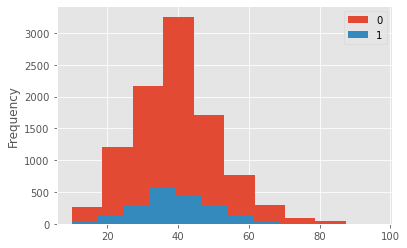

In [24]:
# 기본적인 히스토그램 그려보기 (추천)(중요!!)
bin = 10
dataset[dataset['response'] == 0 ].age.plot.hist(bins = bin) # 응답안한사람의 연령
dataset[dataset['response'] == 1 ].age.plot.hist(bins = bin) # 응답한 사람의 연령
plt.legend([0,1])

히스토그램의 장단점
*   전체 분포를 직관적으로 확인할 수 있다
*   집단간 차이를 볼수 있다. (30-40대에 몰려있음을 알수있음)
*   min값과 max 값을 잘 볼 수 있다. (0 ~100세 사이)
*   빈도가 너무 작은 구간은 비율을 보기 힘들다
*   분포의 크기 구간을 쉽게 늘리거나 줄일 수 있다 (bin으로 조절)

### 구간별 상대비율 히스토그램

<AxesSubplot:xlabel='age_bin'>

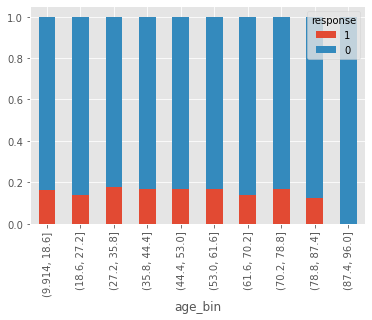

In [23]:
# 각 구간별 상대 비율 히스토 그램 
dataset['age_bin'] = pd.cut(dataset['age'],bins = 10)

temp_1 = pd.DataFrame(dataset.groupby(['response','age_bin']).customer_id.count()).reset_index()
temp_1_pivot = temp_1.pivot(index = 'age_bin',
                            columns= 'response',
                            values = 'customer_id')
temp_1_pivot['row_sum'] = temp_1_pivot.sum(axis=1)
temp_1_pivot[0] = temp_1_pivot[0]/temp_1_pivot['row_sum']
temp_1_pivot[1] = temp_1_pivot[1]/temp_1_pivot['row_sum']
temp_1_pivot[[1,0]].plot.bar(stacked = True )

기본적인 히스토그램과 각 구간별 상대 비율 히스토그램과 함께 보기 !

In [25]:
#  문자형 변수 
print(dataset.groupby(['marital','response']).customer_id.count())
print(dataset.groupby(['marital','response']).customer_id.count()/dataset.shape[0])

marital  response
M        0           2597
         1            502
S        0           4649
         1            901
U        0           2559
         1            549
Name: customer_id, dtype: int64
marital  response
M        0           0.220890
         1           0.042698
S        0           0.395424
         1           0.076635
U        0           0.217658
         1           0.046696
Name: customer_id, dtype: float64


In [26]:
pd.concat([dataset.groupby(['marital','response']).customer_id.count(), dataset.groupby(['marital','response']).customer_id.count()/dataset.shape[0]], axis =1)

customer_id  customer_id
marital response                          
M       0                2597     0.220890
        1                 502     0.042698
S       0                4649     0.395424
        1                 901     0.076635
U       0                2559     0.217658
        1                 549     0.046696

In [27]:
 dataset['marital'].value_counts(normalize=True).sort_index()

M    0.263588
S    0.472059
U    0.264353
Name: marital, dtype: float64

In [ ]:
# 최종적으로 하기 표를 보면, 큰 차이가 없는 것 확인 가능 

In [28]:
pd.crosstab(index = dataset['marital'], columns = dataset['response'],margins = True, margins_name ="total",normalize = 'index').style.format('{:.2%}')

response,0,1
marital,,
M,83.80%,16.20%
S,83.77%,16.23%
U,82.34%,17.66%
total,83.40%,16.60%


### 함수화 (연속형 및 명목형)

In [ ]:
# 변수들을 이해하기 위한 plot 들 많이 생성해보기 !(이해하는 토대가 됨)
# 내가 이해할건 python , 자주 보거나 함께 보는건 태블로 많이 사용

In [29]:
## 연속형 변수 그래프 생성 함수 
def hist_plot (colname, taget_colname, n_bin = 10) : # colname : 그래프 그릴 컬럼명 , taget_colname: n_bin : 구간갯수 

  n_bins = int(n_bin) 
  data['bin'] = pd.cut(data[colname],bins = n_bins)

  temp = data.reset_index().groupby([taget_colname,'bin']).index.count().reset_index() # 구간화
  temp = temp.pivot(index = 'bin',columns = taget_colname, values = 'index')
  temp['row_sum'] = temp.sum(axis = 1) # 각각의 비율을 만들기 위해 구간 합계 생성
  temp['0_rate'] = temp[0]/temp['row_sum'] #각 row의 0의 비율 
  temp['1_rate'] = temp[1]/temp['row_sum'] #각 row의 1의 비율 

  ## 그래프
  fig = plt.figure()
  aig, ax = plt.subplots(ncols = 2 , figsize =(12,5))
  
  ## 첫번째  히스토그램 
  sns.histplot(data = data, x= colname, hue= taget_colname, bins = n_bins, color=['orange','blue'], alpha  = 0.5, hue_order= (0,1), ax= ax[0])

  ## 구간별 타겟비율 그래프
  temp[['0_rate','1_rate']].plot.bar(stacked = True ,ax= ax[1])
  ax[1].legend(labels=[0,1],title =taget_colname) # 범례 순서 바꾸기 
  plt.xlabel(colname)
  plt.show()

<Figure size 432x288 with 0 Axes>

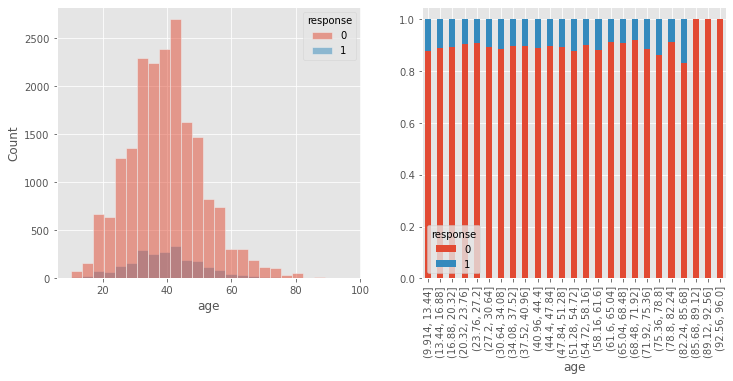

In [30]:
hist_plot('age','response',25 )

In [31]:
# 명속형 변수 그래프 생성 함수 
def bar_plot (colname, taget_colname): # colname : 그래프 그릴 컬럼명 , taget_colname: target 컬럼명

## 그래프용 데이터 생성 
  temp = data.reset_index().groupby([colname,taget_colname]).index.count()
  temp = temp.reset_index()
  temp = temp.pivot(index = colname, columns = taget_colname, values ='index')
  temp['row_sum'] = temp.sum(axis=1)
  temp['0_rate'] = temp[0]/temp['row_sum']
  temp['1_rate'] = temp[1]/temp['row_sum']
 
## 그래프
  fig = plt.figure()
  aig, ax = plt.subplots(ncols = 2 , figsize =(12,5))
## 빈도 막대 그래프 
  temp[[0,1]].plot.bar(stacked = True ,ax= ax[0])
  ax[0].legend(labels=[0,1],title =taget_colname) # 범례 순서 바꾸기 
  plt.xlabel(colname)
## 구간별 타겟 비율 막대 그래프 
  temp[['0_rate','1_rate']].plot.bar(stacked = True ,ax= ax[1])
  ax[1].legend(labels=[0,1],title =taget_colname) # 범례 순서 바꾸기 
  plt.xlabel(colname)
  plt.show()
  
  print(dataset[colname].value_counts(normalize=True).sort_index())
  print(" ")
  print(pd.crosstab(index = dataset[taget_colname], columns = dataset[colname],margins = True, margins_name ="total",normalize = 'columns'))

<Figure size 432x288 with 0 Axes>

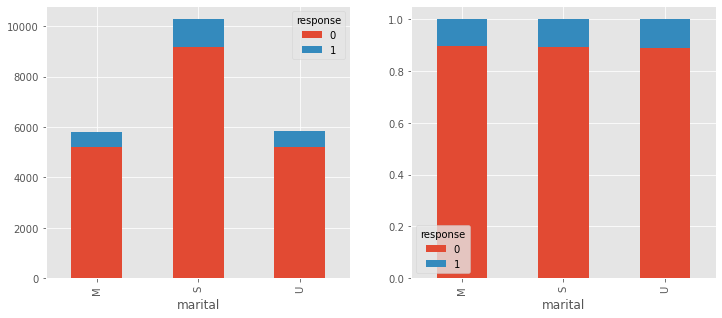

M    0.263588
S    0.472059
U    0.264353
Name: marital, dtype: float64
 
marital          M         S         U     total
response                                        
0         0.838012  0.837658  0.823359  0.833971
1         0.161988  0.162342  0.176641  0.166029


In [32]:
bar_plot('marital','response')

### 4.3 EDA

<Figure size 432x288 with 0 Axes>

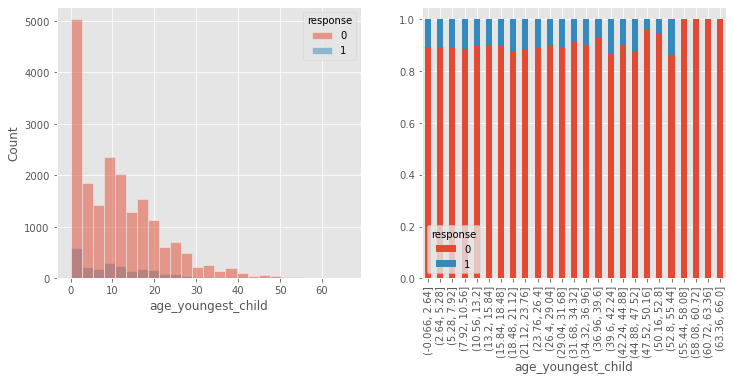

In [33]:
# age_youngest_child
hist_plot('age_youngest_child','response', 25)

## 가장 어린 자녀의 나이가 5세 미만이 가장 많음 - 정말 그럴까? 확인을 하려면?  
## 구간별 큰 target의 비율 차이는 크게 없는것으로 보임 

<Figure size 432x288 with 0 Axes>

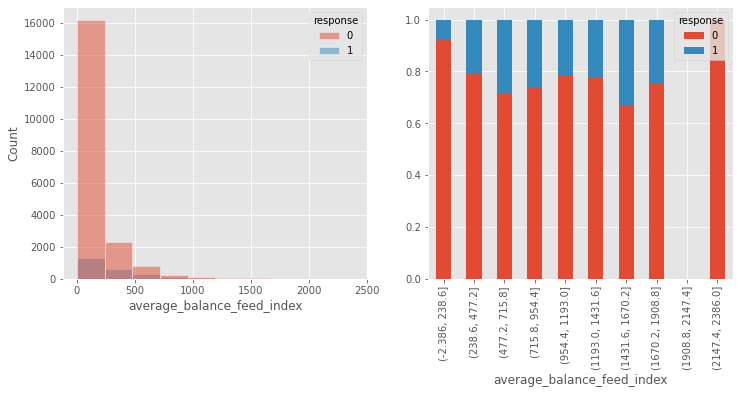

In [34]:
# average_balance_feed_index
hist_plot('average_balance_feed_index','response')

## 평잔이 없는 유저의 비중이 높음 
## 평잔이 낮은 유저가 가장 반응율이 좋음 

<Figure size 432x288 with 0 Axes>

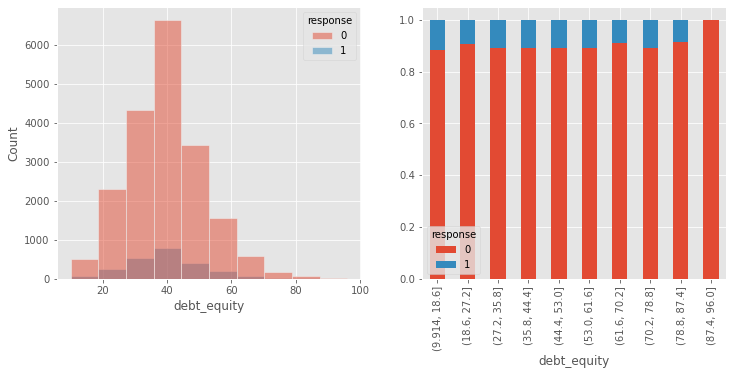

In [35]:
# debt_equity

hist_plot('debt_equity','response')

## 자본대비 부채비율은 40% 대가 가장 많은 유저의 비중을 차지함. (정규 분포 모양)
## 부채 비율이 구간에 따른 응답율은 차이가 없음

<Figure size 432x288 with 0 Axes>

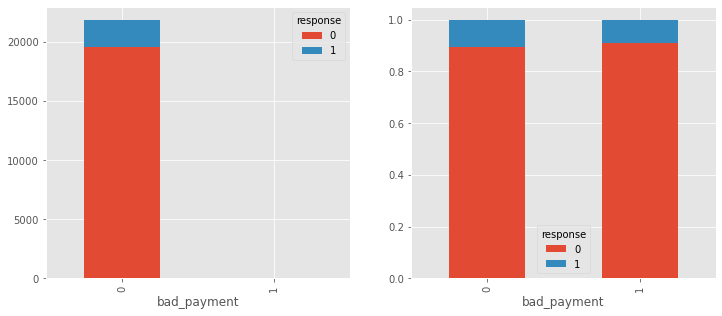

0    0.997193
1    0.002807
Name: bad_payment, dtype: float64
 
bad_payment         0         1     total
response                                 
0            0.833845  0.878788  0.833971
1            0.166155  0.121212  0.166029


In [36]:
# bad_payment 

#hist_plot('bad_payment','response')
bar_plot('bad_payment','response')

## 연체를 안한 유저가 거의 대부임 
## 연채를 안한 유저가 아주 적은 차이로 반응율이 높음

<Figure size 432x288 with 0 Axes>

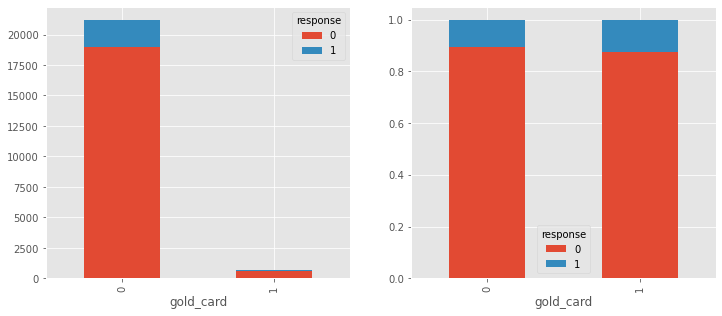

0    0.957387
1    0.042613
Name: gold_card, dtype: float64
 
gold_card         0         1     total
response                               
0          0.833333  0.848303  0.833971
1          0.166667  0.151697  0.166029


In [37]:
# gold_card 

bar_plot('gold_card','response')

## 대부분의 유저가 골드카드를 소지하지 않음 
## 골드 카드 유저가 적은 차이로 반응율이 높음

<Figure size 432x288 with 0 Axes>

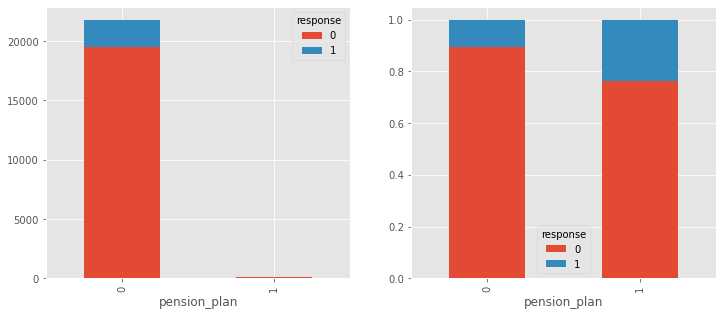

0    0.995832
1    0.004168
Name: pension_plan, dtype: float64
 
pension_plan         0         1     total
response                                  
0             0.835497  0.469388  0.833971
1             0.164503  0.530612  0.166029


In [38]:
# pension_plan

bar_plot('pension_plan','response')

## 대부분의 유저가 골드카드를 소지하지 않음 
## 골드 카드 유저가 적은 차이로 반응율이 높음

<Figure size 432x288 with 0 Axes>

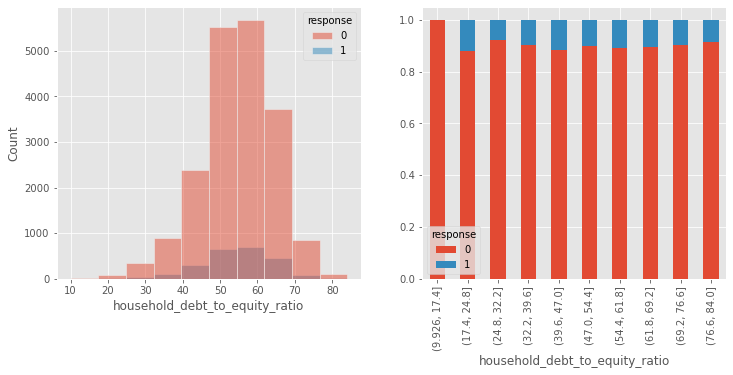

In [39]:
# household_debt_to_equity_ratio

hist_plot('household_debt_to_equity_ratio','response')

## 가계부채 비율은 55~60% 가 가장 높음. (정규 분포 모양)
## 가계부채 비율에 따른 차이는 크지 않은 것으로 보임

<Figure size 432x288 with 0 Axes>

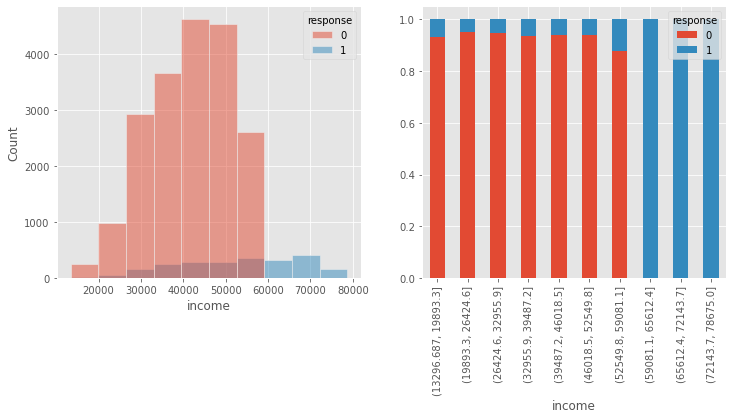

In [41]:
# income

hist_plot('income','response')

## 해당 변수는 데이터가 많이 없어서 빼야 될 것 같은데, 의미있는 변수가 되는지 안되는지 판단
## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

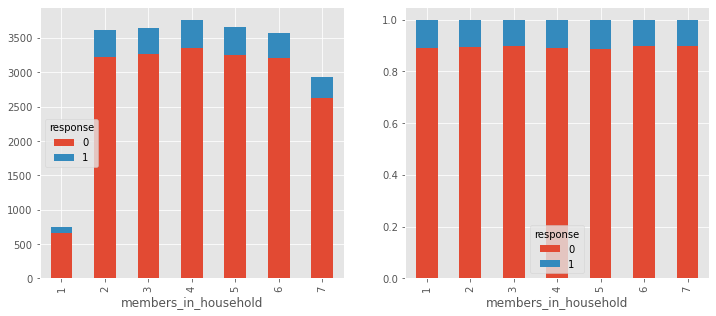

1    0.034788
2    0.167220
3    0.163647
4    0.171217
5    0.166794
6    0.164498
7    0.131836
Name: members_in_household, dtype: float64
 
members_in_household         1         2         3         4         5  \
response                                                                 
0                     0.819071  0.837233  0.835239  0.831595  0.826109   
1                     0.180929  0.162767  0.164761  0.168405  0.173891   

members_in_household         6         7     total  
response                                            
0                     0.840745  0.836774  0.833971  
1                     0.159255  0.163226  0.166029  


In [42]:
# members_in_household

# hist_plot('members_in_household','response')
bar_plot('members_in_household','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

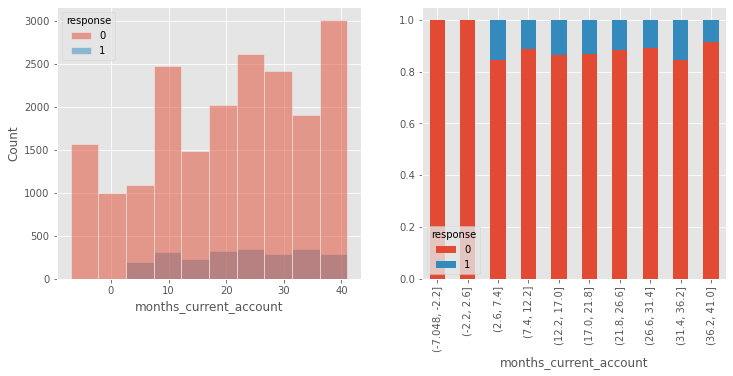

In [43]:
# months_current_account

hist_plot('months_current_account','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

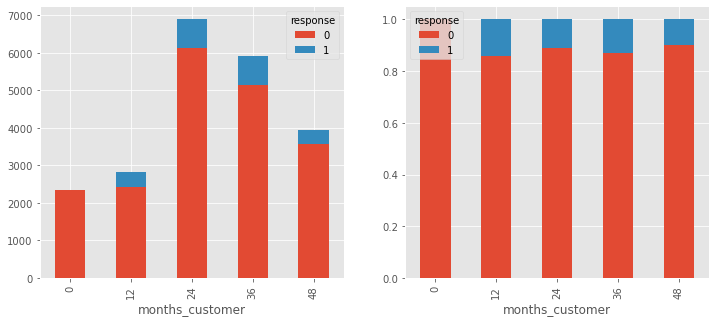

12    0.175300
24    0.332057
36    0.329166
48    0.163477
Name: months_customer, dtype: float64
 
months_customer        12        24        36        48     total
response                                                         
0                0.836487  0.838627  0.834625  0.820499  0.833971
1                0.163513  0.161373  0.165375  0.179501  0.166029


In [44]:
# months_customer

# hist_plot('months_customer','response')
bar_plot('months_customer','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

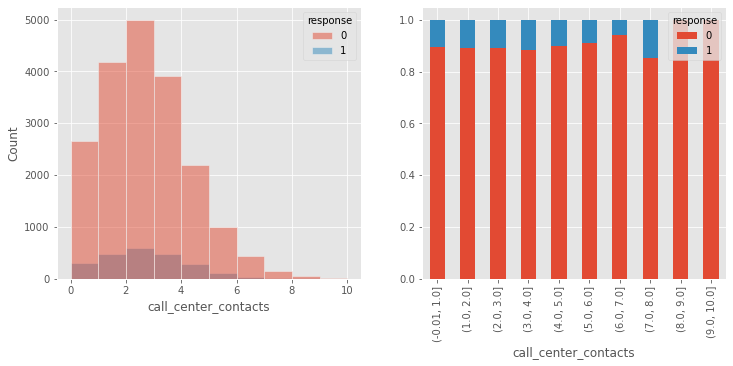

In [45]:
# call_center_contacts

hist_plot('call_center_contacts','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

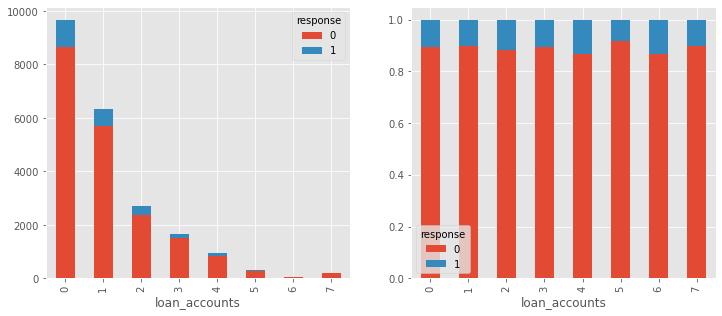

0    0.435060
1    0.291741
2    0.124692
3    0.076125
4    0.045080
5    0.013949
6    0.003232
7    0.010122
Name: loan_accounts, dtype: float64
 
loan_accounts         0        1         2         3        4         5  \
response                                                                  
0              0.835386  0.84344  0.819918  0.830168  0.79434  0.865854   
1              0.164614  0.15656  0.180082  0.169832  0.20566  0.134146   

loan_accounts         6         7     total  
response                                     
0              0.763158  0.857143  0.833971  
1              0.236842  0.142857  0.166029  


In [46]:
# loan_accounts

# hist_plot('loan_accounts','response')
bar_plot('loan_accounts','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

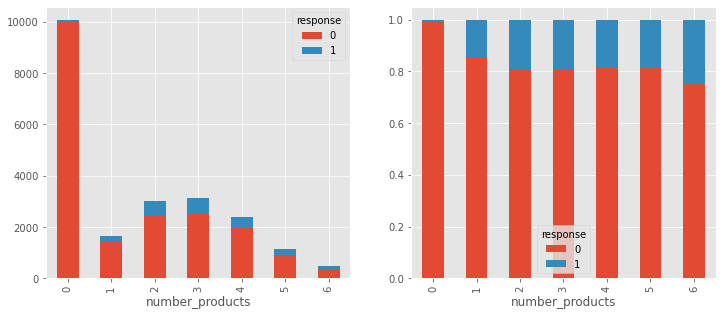

0    0.521051
1    0.053670
2    0.121885
3    0.133708
4    0.101897
5    0.046270
6    0.021519
Name: number_products, dtype: float64
 
number_products         0         1         2         3         4         5  \
response                                                                      
0                0.983023  0.670365  0.666434  0.685751  0.688648  0.658088   
1                0.016977  0.329635  0.333566  0.314249  0.311352  0.341912   

number_products        6     total  
response                            
0                0.56917  0.833971  
1                0.43083  0.166029  


In [47]:
# number_products

# hist_plot('number_products','response')
bar_plot('number_products','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

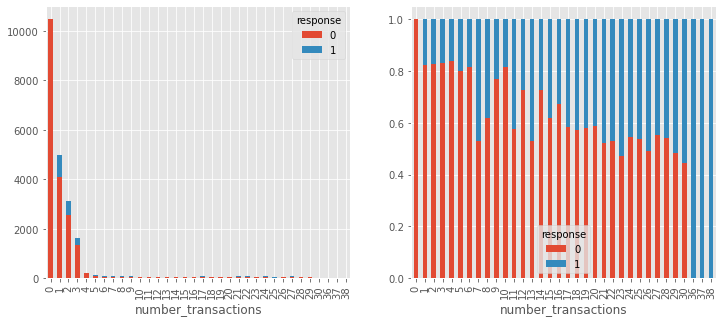

0     0.509994
1     0.205665
2     0.132006
3     0.070341
4     0.008591
5     0.004593
6     0.002722
7     0.003742
8     0.003147
9     0.002892
10    0.002211
11    0.001871
12    0.002637
13    0.002807
14    0.001871
15    0.002552
16    0.002892
17    0.003487
18    0.002892
19    0.003147
20    0.002637
21    0.003232
22    0.003317
23    0.002977
24    0.003062
25    0.002041
26    0.003062
27    0.002977
28    0.002637
29    0.003232
30    0.000510
36    0.000085
37    0.000085
38    0.000085
Name: number_transactions, dtype: float64
 
number_transactions    0        1         2         3         4         5  \
response                                                                    
0                    1.0  0.72043  0.700387  0.711004  0.742574  0.666667   
1                    0.0  0.27957  0.299613  0.288996  0.257426  0.333333   

number_transactions      6         7         8         9        10        11  \
response                                                 

In [48]:
# number_transactions

# hist_plot('number_transactions','response')
bar_plot('number_transactions','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

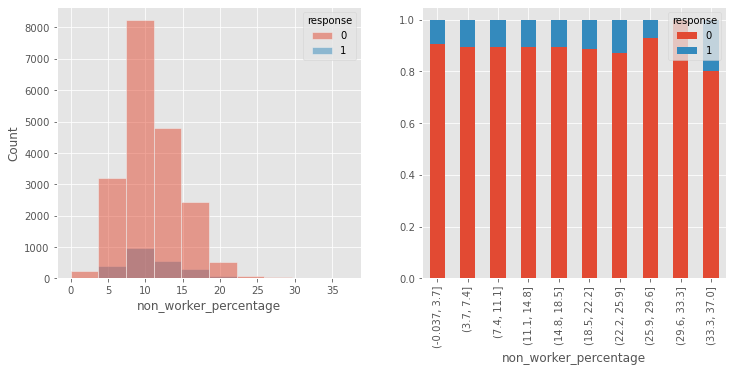

In [49]:
#  non_worker_percentage

hist_plot('non_worker_percentage','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

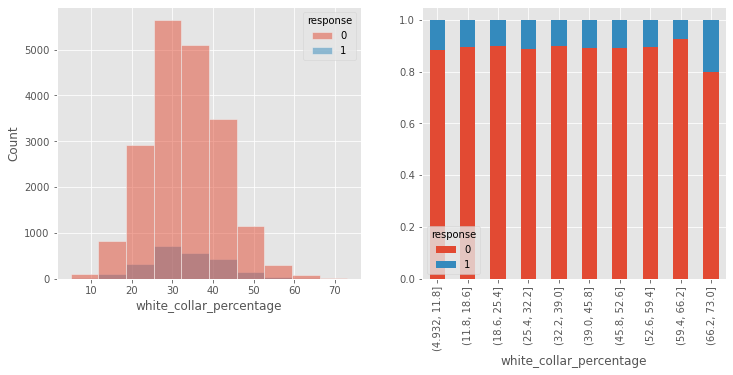

In [50]:
#  white_collar_percentage

hist_plot('white_collar_percentage','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

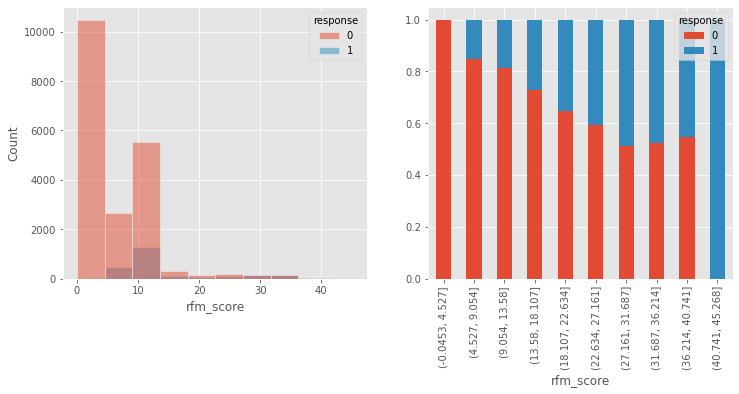

In [51]:
#  rfm_score

hist_plot('rfm_score','response')
# bar_plot('rfm_score','response')

## 빈도 
## target 비율

<Figure size 432x288 with 0 Axes>

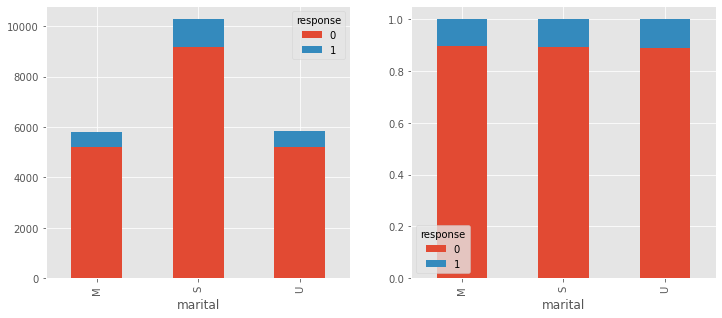

M    0.263588
S    0.472059
U    0.264353
Name: marital, dtype: float64
 
marital          M         S         U     total
response                                        
0         0.838012  0.837658  0.823359  0.833971
1         0.161988  0.162342  0.176641  0.166029


In [52]:
# marital

# hist_plot('rfm_score','response')
bar_plot('marital','response')

## 빈도 
## target 비율

## 5.정리 #####
#### 1. 데이터를 tidy 한 형태로 구성  
#### 2. campaign 2 번 데이터 사용 
#### 3. 이상치를 제외후 사용할 수 있으나 데이터수가 적고 의미를 파악하기 어려워 변수를 제외       

## *6*. 모델링 


### 6.1 모델링을 의한 데이터 선택

In [53]:
# 모델에 사용할 데이터 선택 
dataset.reset_index(inplace =True)
dataset_for_ml =dataset[['response','age','age_youngest_child','average_balance_feed_index','debt_equity','gender','bad_payment',
                         'gold_card','pension_plan','household_debt_to_equity_ratio','income','marital','members_in_household',
                         'months_current_account','months_current_account','months_customer','call_center_contacts','loan_accounts',
                         'number_products','number_transactions','non_worker_percentage','white_collar_percentage','X_random']]

### 6.2 문자형 변수 더미변수로 변환 

In [54]:
#one hot encoding

dataset_for_ml_dm = pd.get_dummies(dataset_for_ml)

dataset_for_ml_dm.info()

## 강의 다시 보기 !

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   response                        11757 non-null  int64  
 1   age                             11757 non-null  int64  
 2   age_youngest_child              11757 non-null  int64  
 3   average_balance_feed_index      11757 non-null  int64  
 4   debt_equity                     11757 non-null  int64  
 5   bad_payment                     11757 non-null  int64  
 6   gold_card                       11757 non-null  int64  
 7   pension_plan                    11757 non-null  int64  
 8   household_debt_to_equity_ratio  11757 non-null  int64  
 9   income                          11757 non-null  float64
 10  members_in_household            11757 non-null  int64  
 11  months_current_account          11757 non-null  int64  
 12  months_current_account          

### 6.3 학습 확인 데이터 셋 분리

In [55]:
##새로운 데이터로 했을떄 얼마나 잘 맞는지 확인하고 싶기때문에 학습데이터, 실습데이터 나눔
## 실무에서는 데이터가 많지 않기때문에 7:3 or 8:2 (최대한 학습 많이 하게 됨)

# 전체를 랜덤하게 나눈법 
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

# 변수로 들어있는 X_random 사용
X_train = dataset_for_ml_dm[dataset_for_ml_dm['X_random'] <= 2].drop(['X_random','response'], axis =1 )
X_test = dataset_for_ml_dm[dataset_for_ml_dm['X_random'] > 2].drop(['X_random','response'], axis =1 )
y_train = dataset_for_ml_dm[dataset_for_ml_dm['X_random']<= 2].response
y_test = dataset_for_ml_dm[dataset_for_ml_dm['X_random']> 2].response

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7792, 24)
X_test shape:  (3965, 24)
y_train shape:  (7792,)
y_test shape:  (3965,)


### 6.4 모델 학습 및 평가

In [56]:
#RandomForest

model = RandomForestClassifier(n_estimators = 100, random_state=0)
model.fit(X_train, y_train)

#예측값(predict)
y_pred = model.predict(X_test)

result = pd.DataFrame({'pred' : y_pred, 'real' : y_test})

result.head(10)

,pred,real
3,0,0
6,0,0
11,0,0
12,0,0
16,0,1
17,0,0
21,0,0
22,0,0
29,0,0
35,0,0


In [57]:
# 정확도 확인(얼마나 잘 맞췄는지 확인)
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy : 0.9102


### 6.5 하이퍼 마라메터 튜닝 

In [58]:
# GridSearchCV의 param_grid 설정
# 찾고자 하는 parameter 정의 
params = {
    'n_estimators': [100, 150, 200, 250], # 반복 횟수 100번, 150번, 200번, 250번 으로 총 3번 돌려봐
    #'max_depth': [6, 9]
    #'min_samples_split': [0.01, 0.05, 0.1],
    'max_features': ['auto', 'log2'], #변수를 몇개 자동으로 뽑을래? log2로 뽑아서 샘플링 할래?
}

### 4번 * 2번 = 총 8번 돌려짐


# 사용하고자 하는 모델 정의
rtc = RandomForestClassifier()

# n_jobs=-1 -> 모든 코어 사용 (속도빨라짐) 
# verbose로 log 출력의 level을 조정 (숫자가 클 수록 많은 log 출력) 
grid_tree = GridSearchCV(rtc, param_grid=params, cv=3,
                           n_jobs=-1,verbose=2) 
grid_tree.fit(X_train, y_train)

grid_tree.best_params_

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)



#randomForest : 파라미터 튜닝에 잘 안해도 민감하지 않음 (변수, 파라미터 등을 랜덤으로 잘 뽑음)
# Xboost 도 정확도(파라미터튜닝 많이할경우), 랜덤포레스트: 안정적 
# --> 시간 있으면 Xboost 도 괜찮지만, 거의 랜덤포레스트로 돌리면 잘 나옴(평타 이상)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
best parameters :  {'max_features': 'auto', 'n_estimators': 100}
best score :  0.7873513575255947


### 6.6 최종 모델 선택 

In [60]:
model = RandomForestClassifier(n_estimators = 100,max_features= 'log2', random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

result = pd.DataFrame({'pred' : y_pred, 'real' : y_test})
print(result)

       pred  real
3         0     0
6         0     0
11        0     0
12        0     0
16        0     1
17        0     0
21        0     0
22        0     0
29        0     0
35        0     0
38        0     0
42        0     0
43        0     0
45        0     0
49        0     0
51        0     0
53        0     0
56        0     0
59        0     1
65        0     0
67        0     0
68        0     0
76        0     0
77        0     0
78        0     0
79        0     0
89        0     0
90        0     0
93        0     0
95        0     0
96        0     0
97        0     0
98        0     0
99        0     0
100       0     1
103       0     0
107       0     0
113       0     0
119       0     0
121       0     0
126       0     0
130       0     0
134       0     0
136       0     0
144       0     0
148       0     0
149       0     0
150       0     0
153       0     0
156       0     0
159       0     0
163       0     1
165       0     1
167       0     0
168       

### 6.7 최종 지표 확인 

In [61]:
# confusion matrix 확인 
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

## weighted_avg 의 precision, recall, f1-score, support 값 확인!

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3293
           1       0.93      0.51      0.66       672

    accuracy                           0.91      3965
   macro avg       0.92      0.75      0.80      3965
weighted avg       0.91      0.91      0.90      3965



In [ ]:
# precision: 반응 x -> 진짜 반응 x
# 전체 반응x -> 커버?
# support : 반응 o 
###########강의 확인하기 !

In [ ]:
# 각 모델 평가할때 roc curve 확인

C:\Users\Miyoung\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


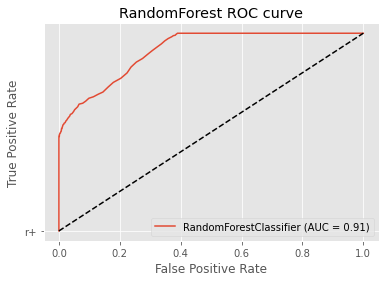

NameError: name 'roc_auc_score' is not defined

In [63]:
# roc cruve 확인
from sklearn import metrics

metrics.plot_roc_curve(model, X_test, y_test) 
plt.plot([0,1], [0,1], "k--", "r+")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC curve')
plt.show()
print("test_AUC : ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

In [64]:
# Feature별 importance 확인(참고만, 절대적이진 않음)
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

income                            0.338930
number_transactions               0.106101
average_balance_feed_index        0.104794
number_products                   0.074997
white_collar_percentage           0.038301
household_debt_to_equity_ratio    0.036325
months_current_account            0.034548
debt_equity                       0.034164
non_worker_percentage             0.033679
age                               0.033585
months_current_account            0.032488
age_youngest_child                0.029853
members_in_household              0.023571
loan_accounts                     0.019473
call_center_contacts              0.015869
months_customer                   0.009431
gender_M                          0.006459
gender_F                          0.006322
marital_U                         0.005672
marital_S                         0.005433
marital_M                         0.005153
gold_card                         0.003916
pension_plan                      0.000794
bad_payment

## 한번 해보기 

*  구매를 target(label)을 기반으로 모델을 만들어 보기 